# Building Autoencoders in Keras
    
    A Simple autoencoder based on a fully-connected layer
    A Sparse autoencoder
    A Deep fully-connected autoencoder
    A Deep convolutional autoencoder
    An Image denoising model
    A Sequence-to-sequence autoencoder
    A Variational autoencoder

In [1]:
## "Autoencoding" is a data compression algorithm where the compression and decompression functions are 
## 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human.
## Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression
## functions are implemented with neural networks.

In [2]:
## One setback is Autoencoders are lossy, i.e. they losse sm info when compressing data,
## and so the new i8mage is a little degraded

### A Simple autoencoder

In [4]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [13]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
## Loading the dataset

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [15]:
## training the model

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 27us/sample - loss: 0.0678 - val_loss: 0.0412
Epoch 2/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0348 - val_loss: 0.0295
Epoch 3/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0266 - val_loss: 0.0235
Epoch 4/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0217 - val_loss: 0.0195
Epoch 5/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0183 - val_loss: 0.0166
Epoch 6/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0160 - val_loss: 0.0147
Epoch 7/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0143 - val_loss: 0.0133
Epoch 8/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0131 - val_loss: 0.0122
Epoch 9/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0122 - val_

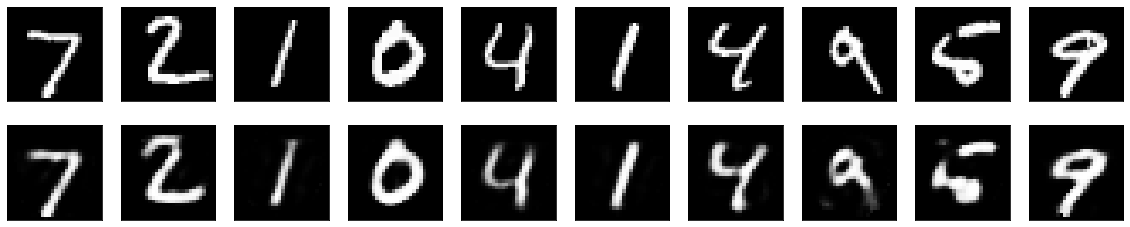

In [16]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
def plot_imgs(decoded_imgs):
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Adding a sparsity constraint on the encoded representations

In [11]:
## What typically happens is that the hidden layer is learning an approx. of PCA (principal component analysis).
## But another way to constrain the representations to be compact is to add a sparsity contraint on the activity
## of the hidden representations, so fewer units would "fire" at a given time.
## In Keras, this can be done by adding an activity_regularizer to our Dense layer

In [18]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [19]:
autoencoder.compile(optimizer='adam', loss='mse')

## training the model

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0772 - val_loss: 0.0463
Epoch 2/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0402 - val_loss: 0.0349
Epoch 3/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0322 - val_loss: 0.0292
Epoch 4/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0275 - val_loss: 0.0253
Epoch 5/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0244 - val_loss: 0.0228
Epoch 6/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0222 - val_loss: 0.0209
Epoch 7/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0206 - val_loss: 0.0196
Epoch 8/50
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0195 - val_loss: 0.0187
Epoch 9/50
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0187 - val_

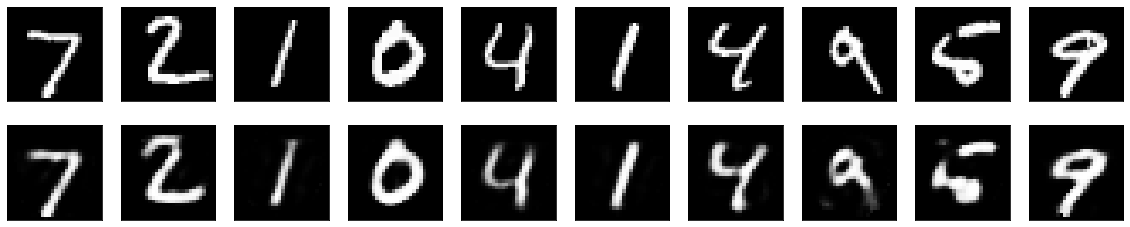

In [20]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep autoencoder

In [21]:
## We do not have to limit ourselves to a single layer as encoder or decoder, 
## we could instead use a stack of layers

In [22]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [24]:
## trainig n compiling

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 192us/sample - loss: 0.0641 - val_loss: 0.0383
Epoch 2/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0319 - val_loss: 0.0262
Epoch 3/100
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0237 - val_loss: 0.0211
Epoch 4/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0203 - val_loss: 0.0184
Epoch 5/100
60000/60000 [==============================] - 9s 145us/sample - loss: 0.0181 - val_loss: 0.0169
Epoch 6/100
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0168 - val_loss: 0.0158
Epoch 7/100
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0158 - val_loss: 0.0150
Epoch 8/100
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0150 - val_loss: 0.0143
Epoch 9/100
60000/60000 [==============================] - 8s 137us/sample - 

60000/60000 [==============================] - 2s 31us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 76/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 77/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 78/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 79/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 80/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 81/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 82/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 83/100
60000/60000 [==============================] - 2s 31us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 84/100
60000/60000 [======

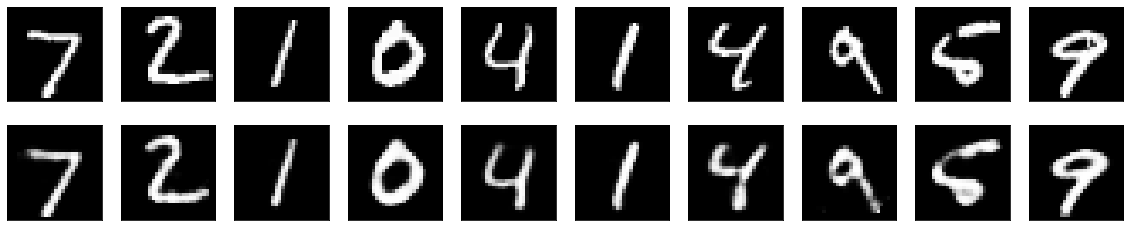

In [28]:
decoded_imgs = autoencoder.predict(x_test)

plot_imgs(decoded_imgs)

### Convolutional autoencoder

In [26]:
## Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders 
## and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders 
## --they simply perform much better.

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [33]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [43]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 2/50
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 3/50
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 4/50
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 5/50
60000/60000 [==============================] - 81s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 6/50
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 7/50
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 8/50
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.1120 - val_loss: 0.1140
Epoch 9/50
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.1120 - val_

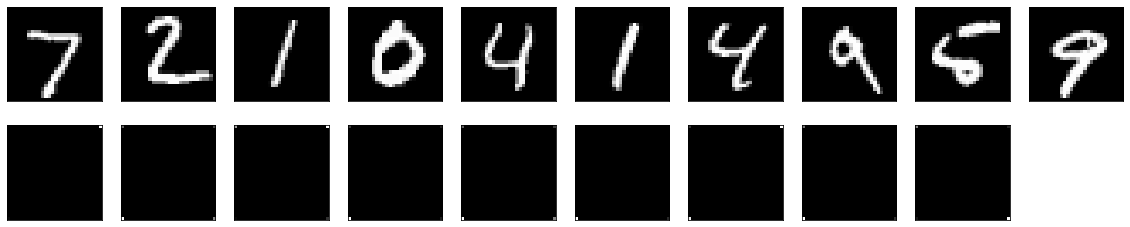

In [44]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### Image Denoising

In [45]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

## adding noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

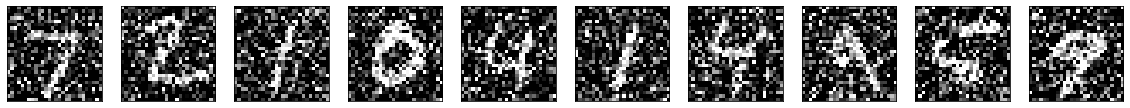

In [46]:
## the noisy images look like:

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [47]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [48]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
19456/60000 [========>.....................] - ETA: 1:35 - loss: 0.1150

KeyboardInterrupt: 

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_imgs(decoded_imgs)

### Variational autoencoder (VAE)

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

In [ ]:
## encoder model

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [ ]:
## mapping the sample latent points

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [ ]:
## so far we have these 3 models

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
## We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, 
## and the KL divergence regularization term.

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [ ]:
## training the model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
## since VAE is a generative model, wwe can use it to generate new digits

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()